In [51]:
# ANOTHER change 

import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
import h5py
import yaml
from astropy.constants import G

import matplotlib
import matplotlib.pyplot as plt
import os
os.environ["PATH"] += os.pathsep + "/Library/TeX/texbin"
plt.style.use('my_standard.mplstyle')
import gala
from gala.coordinates import OrphanKoposov19, GD1Koposov10

galcen_v_sun = (11.1, 245, 7.3)*u.km/u.s
galcen_distance = 8.249*u.kpc

In [14]:
# for i in range(0, 1024):
#     param = "param_{}.yaml".format(i)
#     with open("/mnt/ceph/users/rbrooks/oceanus/ics/em-mwh-full-mwd-full-lmc/" + param, 'r') as yaml_file:
#         data = yaml.safe_load(yaml_file)

#     data['Tbegin'] = -5.
#     data['dtmin'] = 0.0005
#     data['strip_rate'] = 10
    
#     with open("/mnt/ceph/users/rbrooks/oceanus/ics/em-mwh-full-mwd-full-lmc/" + param, 'w') as file:
#         yaml.dump(data, file)

In [48]:
# with open("Tasks.txt", "w") as file:

#     for i in range(128):

#         file.write("source /mnt/home/rbrooks/ceph/venvs/mwlmc_venv/bin/activate ; python3 /mnt/home/rbrooks/ceph/oceanus/src/streamgenerator.py /mnt/home/rbrooks/ceph/oceanus/ics/ics-yaml-files/param_{}.yaml\n".format(i))

In [500]:
with h5py.File('stream-runs/combined-files/Full-MWhalo-MWdisc-LMC.hdf5','r') as file:
    
    # keys = list(file['stream_0'].keys())
    
    pos = np.array(file['stream_3']['positions'])
    vel = np.array(file['stream_3']['velocities'])
    start_times = np.array(file['stream_3']['times'])
    prog_mass = np.array(file['stream_3']['progenitor-mass'])

In [501]:
prog_mass

array(31230.73941094)

### Rotation into stream progentior frame

In [502]:
from scipy.spatial.transform import Rotation
import scipy

Take the final snapshot positions/velocities and transform to spherical galactocentric coordinates

In [589]:
t0_pos, t0_vel = pos[-1], vel[-1]
t0_prog_pos, t0_prog_vel = t0_pos[0], t0_vel[0]

gc_cart = SkyCoord(x=t0_prog_pos[0]*u.kpc, y=t0_prog_pos[1]*u.kpc, z=t0_prog_pos[2]*u.kpc,
                   v_x=t0_prog_vel[0]*u.km/u.s, v_y=t0_prog_vel[1]*u.km/u.s, v_z=t0_prog_vel[2]*u.km/u.s,
                   frame='galactocentric',  galcen_v_sun=galcen_v_sun, galcen_distance=galcen_distance)

gc_sph = gc_cart.transform_to('galactic')
gc_sph_rc = gala.coordinates.reflex_correct(gc_sph)
t0_prog_pos, t0_prog_vel

(array([ 1.87966067, -4.78414227,  3.07257542]),
 array([-47.32739528,   4.8038478 ,  54.42055701]))

In [504]:
prog_lon, prog_lat = gc_sph_rc.l.deg, gc_sph_rc.b.deg
prog_lon, prog_lat

(334.7000311689924, 15.370356672540558)

Find the coordinate transform of the progenitor i) position and ii) velocity, around the z then y axis

In [604]:
R1 = Rotation.from_euler('z', -prog_lon, degrees=True)
R2 = Rotation.from_euler('y', -prog_lat, degrees=True)
R_prog0 = R2.as_matrix() @ R1.as_matrix() 
R_prog0

array([[ 0.87174615, -0.41207194, -0.26505728],
       [ 0.42735737,  0.90408278,  0.        ],
       [ 0.23963373, -0.11327418,  0.96423267]])

In [605]:
rot_prog_pos = R_prog0 @ t0_prog_pos
rot_prog_vel = R_prog0 @ t0_prog_vel
# rot_prog_vel[2] = 0
rot_prog_pos, rot_prog_vel

(array([ 2.79558923, -3.52197381,  3.9550275 ]),
 array([-57.66157065, -15.88263516,  40.58868675]))

In [606]:
z_normal =  np.array([0.,0.,rot_prog_vel[2]])

vel_cos_theta = (np.dot(rot_prog_vel, z_normal)/(scipy.linalg.norm(rot_prog_vel)*scipy.linalg.norm(z_normal)))
vel_ang_xy_rad = np.arccos(vel_cos_theta)*u.rad
vel_ang_xy_deg = vel_ang_xy_rad.to(u.deg)

vel_ang_xy_deg

<Quantity 55.83767025 deg>

In [607]:
R3 = Rotation.from_euler('x', vel_ang_xy_deg.value, degrees=True).as_matrix() # is this x/z?
R_progf = R3 @ R_prog0
R_progf

array([[ 0.87174615, -0.41207194, -0.26505728],
       [ 0.04169312,  0.60140689, -0.79785427],
       [ 0.48818063,  0.68447533,  0.54145471]])

In [608]:
rot_stream_xs = np.dot(R_progf, t0_pos.T).T
rot_stream_vs = np.dot(R_progf, t0_vel.T).T

In [609]:
rot_stream_xs[0], rot_stream_vs[0]

(array([ 2.79558923, -5.25031463, -0.69335298]),
 array([-57.66157065, -42.50383338,   9.65006424]))

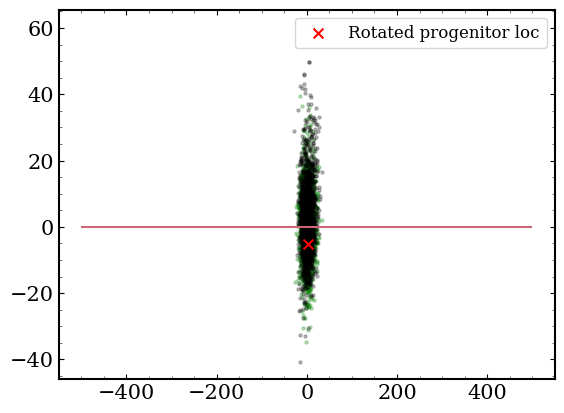

In [610]:
plt.scatter(t0_pos[:,0],t0_pos[:,1], s=5, c='g', alpha=.25)

plt.scatter(rot_stream_xs[:,0],rot_stream_xs[:,1], s=5, c='k', alpha=.25)
plt.scatter(rot_stream_xs[0][0],rot_stream_xs[0][1], s=50, c='r', marker='x', label='Rotated progenitor loc')
# plt.scatter(0,0, s=50, c='g', marker='o', label='Expected progenitor loc')
plt.hlines(0, -500,500)
plt.legend()
# plt.xlim(420,450)
# plt.ylim(-20,20)

In [270]:
# int_keys = np.array([int(x.split("_")[1]) for x in keys])
# idx = np.arange(1024)
# idx[~np.isin(idx, int_keys)]

In [14]:
# leapfrog_final_xs_oc, leapfrog_final_vs_oc = pos_oc[-1], vel_oc[-1]

# leapfrog_final_xs_gd, leapfrog_final_vs_gd = pos_gd[-1], vel_gd[-1]

In [37]:
gc_oc = SkyCoord(x=leapfrog_final_xs_oc[:,0]*u.kpc, y=leapfrog_final_xs_oc[:,1]*u.kpc, z=leapfrog_final_xs_oc[:,2]*u.kpc,
                          v_x=leapfrog_final_vs_oc[:,0]*u.km/u.s, v_y=leapfrog_final_vs_oc[:,1]*u.km/u.s, v_z=leapfrog_final_vs_oc[:,2]*u.km/u.s,
                          frame='galactocentric',  galcen_v_sun=galcen_v_sun, galcen_distance=galcen_distance)

gc_trans_oc = gc_oc.transform_to(OrphanKoposov19)
gc_trans_rc_oc = gala.coordinates.reflex_correct(gc_trans_oc)


gc_gd = SkyCoord(x=leapfrog_final_xs_gd[:,0]*u.kpc, y=leapfrog_final_xs_gd[:,1]*u.kpc, z=leapfrog_final_xs_gd[:,2]*u.kpc,
                          v_x=leapfrog_final_vs_gd[:,0]*u.km/u.s, v_y=leapfrog_final_vs_gd[:,1]*u.km/u.s, v_z=leapfrog_final_vs_gd[:,2]*u.km/u.s,
                          frame='galactocentric',  galcen_v_sun=galcen_v_sun, galcen_distance=galcen_distance)

gc_trans_gd = gc_gd.transform_to(GD1Koposov10)
gc_trans_rc_gd = gala.coordinates.reflex_correct(gc_trans_gd)

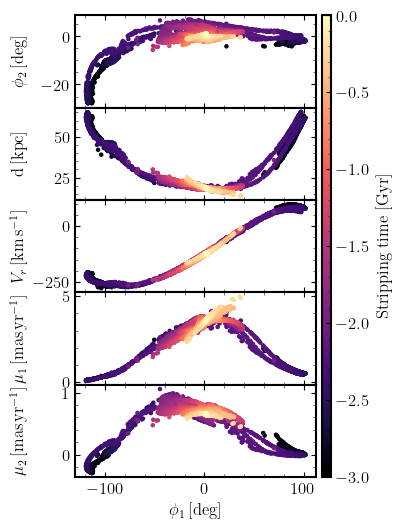

In [38]:
fig_observables, ax = plt.subplots(5,1, sharex='col', sharey='row', figsize=(3.75,6))

for i in range(5):
    ax[i].tick_params(labelsize=12)
plt.subplots_adjust(hspace=0, wspace=0.)
        
# phi1 vs phi2
plot= ax[0].scatter(gc_trans_rc_oc.phi1, gc_trans_rc_oc.phi2,s=5, c=start_times_oc, rasterized=True)
ax[0].set_ylabel('$\phi_{2}\,[\mathrm{deg}]$')

# phi1 vs distance
ax[1].scatter(gc_trans_rc_oc.phi1, gc_trans_rc_oc.distance,s=5, c=start_times_oc,  rasterized=True)
ax[1].set_ylabel('$\mathrm{d}\,[\mathrm{kpc}]$')

# phi1 vs Vr
ax[2].scatter(gc_trans_rc_oc.phi1, gc_trans_rc_oc.radial_velocity, s=5,c=start_times_oc, rasterized=True)
ax[2].set_ylabel('$V_{r}\,[\mathrm{km}\,\mathrm{s}^{-1}]$')

# phi1 vs pm1
ax[3].scatter(gc_trans_rc_oc.phi1, gc_trans_rc_oc.pm_phi1_cosphi2,s=5, c=start_times_oc, rasterized=True)
ax[3].set_ylabel('$\mu_{1}\,[\mathrm{mas}\,\mathrm{yr}^{-1}]$')

ax[4].scatter(gc_trans_rc_oc.phi1, gc_trans_rc_oc.pm_phi2, s=5,c=start_times_oc, rasterized=True)
ax[4].set_xlabel('$\phi_{1}\,[\mathrm{deg}]$')
ax[4].set_ylabel('$\mu_{2}\,[\mathrm{mas}\,\mathrm{yr}^{-1}]$')


cb = fig_observables.colorbar(plot,  ax=ax, location='right', aspect=50, pad=0.02)
cb.set_label(r'Stripping time [Gyr]')
cb.ax.tick_params(labelsize=12)

fig_observables.align_labels()

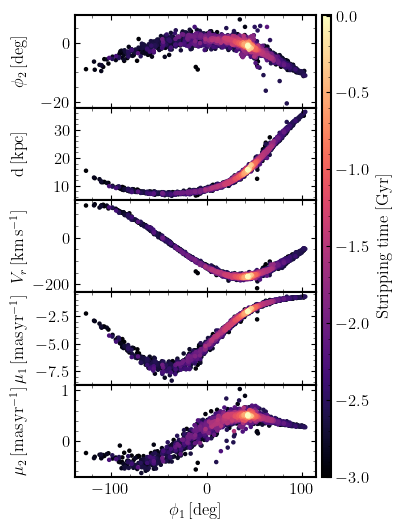

In [39]:
fig_observables, ax = plt.subplots(5,1, sharex='col', sharey='row', figsize=(3.75,6))

for i in range(5):
    ax[i].tick_params(labelsize=12)
plt.subplots_adjust(hspace=0, wspace=0.)
        
# phi1 vs phi2
plot= ax[0].scatter(gc_trans_rc_gd.phi1, gc_trans_rc_gd.phi2,s=5, c=start_times_gd, rasterized=True)
ax[0].set_ylabel('$\phi_{2}\,[\mathrm{deg}]$')

# phi1 vs distance
ax[1].scatter(gc_trans_rc_gd.phi1, gc_trans_rc_gd.distance,s=5, c=start_times_gd,  rasterized=True)
ax[1].set_ylabel('$\mathrm{d}\,[\mathrm{kpc}]$')

# phi1 vs Vr
ax[2].scatter(gc_trans_rc_gd.phi1, gc_trans_rc_gd.radial_velocity, s=5,c=start_times_gd, rasterized=True)
ax[2].set_ylabel('$V_{r}\,[\mathrm{km}\,\mathrm{s}^{-1}]$')

# phi1 vs pm1
ax[3].scatter(gc_trans_rc_gd.phi1, gc_trans_rc_gd.pm_phi1_cosphi2,s=5, c=start_times_gd, rasterized=True)
ax[3].set_ylabel('$\mu_{1}\,[\mathrm{mas}\,\mathrm{yr}^{-1}]$')

ax[4].scatter(gc_trans_rc_gd.phi1, gc_trans_rc_gd.pm_phi2, s=5,c=start_times_gd, rasterized=True)
ax[4].set_xlabel('$\phi_{1}\,[\mathrm{deg}]$')
ax[4].set_ylabel('$\mu_{2}\,[\mathrm{mas}\,\mathrm{yr}^{-1}]$')


cb = fig_observables.colorbar(plot,  ax=ax, location='right', aspect=50, pad=0.02)
cb.set_label(r'Stripping time [Gyr]')
cb.ax.tick_params(labelsize=12)

fig_observables.align_labels()